# Operational contracts in object detection

Goal: make the detection pipeline inspectable:
candidates (boxes + scores) -> threshold -> IoU -> NMS.

Each step is in its own cell so you can see behavior changes clearly.

## 1. Workspace information

In [ ]:
!uname -a

!free -h || true

!cat /proc/cpuinfo | head -n 20 || true

Linux 42849db6c3ad 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
               total        used        free      shared  buff/cache   available
Mem:            12Gi       609Mi       9.0Gi       2.0Mi       3.1Gi        11Gi
Swap:             0B          0B          0B
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.190
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp f

## 2. Workspace setup (Colab-friendly)

In [ ]:
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

import os
import glob

my_name = '01_pytorch_detection_contract.ipynb'
my_path = glob.glob(os.getcwd() + '/**/' + my_name, recursive=True)

if my_path:
    nb_dir = os.path.dirname(my_path[0])
    os.chdir(os.path.abspath(os.path.join(nb_dir, '..')))

print("Current dir:", os.getcwd())
!ls


Current dir: /content
sample_data


## 3. Load demo images

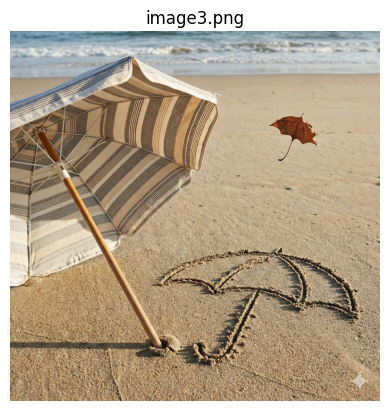

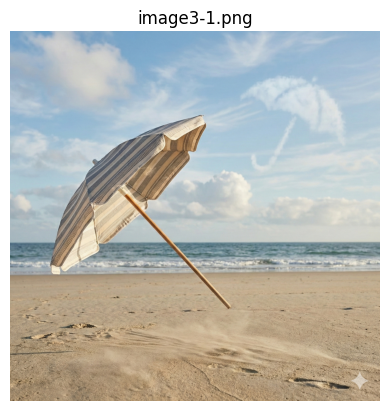

In [6]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

img_dir = Path("data/input/images")
img1 = Image.open(img_dir / "image3.png").convert("RGB")
img2 = Image.open(img_dir / "image3-1.png").convert("RGB")

def show(img, title: str) -> None:
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

show(img1, "image3.png")
show(img2, "image3-1.png")


## 4. Install PyTorch stack
This notebook aligns with SSD + MobileNet in PyTorch.

In [7]:
!pip -q install -r requirements-dev.txt
!pip -q install -r requirements-torch.txt
!pytest -q
#!ruff check .

.....                                                                    [100%]
5 passed in 1.99s


## 5. Run a real detector (torchvision SSD + MobileNet)
Pretrained detectors may output few boxes on synthetic images. That is fine.

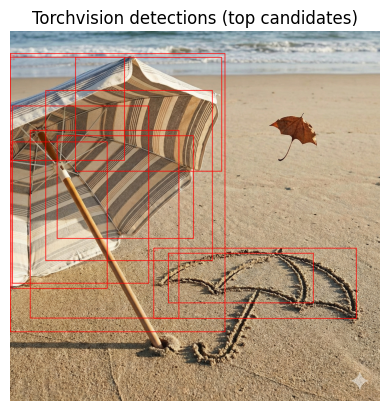

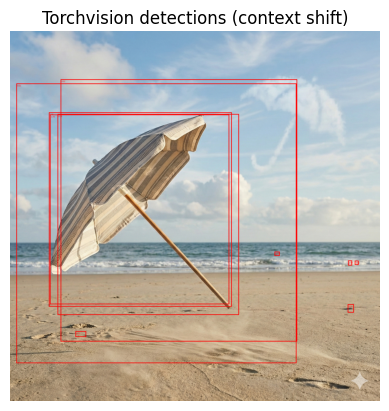

20 [0.9672471880912781, 0.5687613487243652, 0.1908974051475525, 0.17842276394367218, 0.16044016182422638]
20 [0.7795307636260986, 0.380480021238327, 0.05184782296419144, 0.024789702147245407, 0.02109297551214695]


In [30]:
from src.torchvision_det import run_torchvision_ssd_mobilenet
from src.viz import draw_boxes

res = run_torchvision_ssd_mobilenet(img1, max_detections=20)
res2 = run_torchvision_ssd_mobilenet(img2, max_detections=20)

vis = draw_boxes(img1, res.boxes[:10], scores=res.scores[:10], color="red")
vis2 = draw_boxes(img2, res2.boxes[:10], scores=res2.scores[:10], color="red")

show(vis, "Torchvision detections (top candidates)")
show(vis2, "Torchvision detections (context shift)")

print(len(res.boxes), res.scores[:5])
print(len(res2.boxes), res2.scores[:5])


## Contract demo (framework-independent)
Even if a pretrained detector outputs little on synthetic images, the contract is the point.
We create toy duplicates to make thresholding and NMS effects visible.

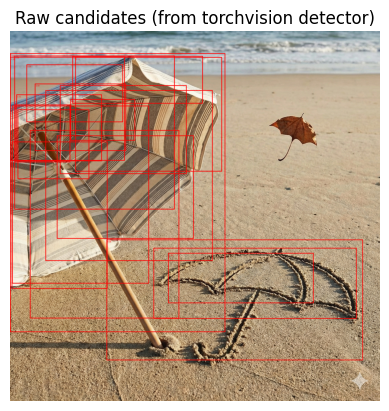

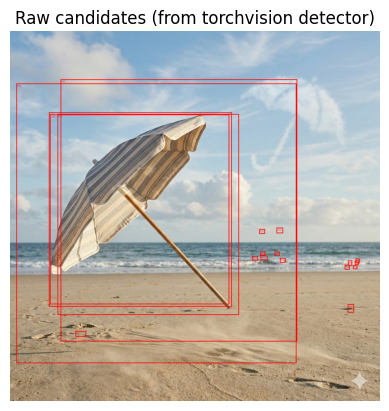

In [31]:
from src.boxes import Box
from src.contracts import apply_threshold, nms
from src.viz import draw_boxes

# Using the actual results from the torchvision detector
real_boxes = res.boxes
real_boxes2 = res2.boxes

real_scores = res.scores
real_scores2 = res2.scores

raw = draw_boxes(img1, real_boxes, scores=real_scores, color="red")
raw2 = draw_boxes(img2, real_boxes2, scores=real_scores2, color="red")

show(raw, "Raw candidates (from torchvision detector)")
show(raw2, "Raw candidates (from torchvision detector)")

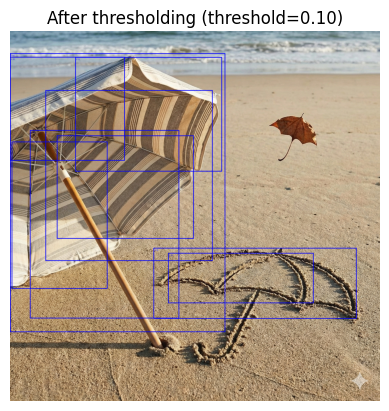

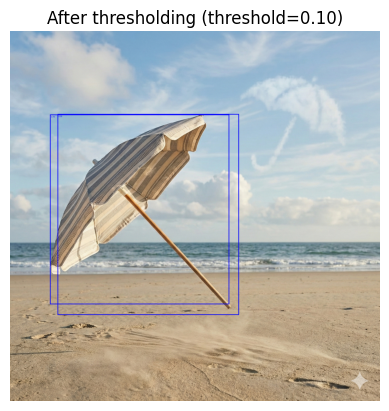

In [28]:
thr = 0.10
b, s = apply_threshold(real_boxes, real_scores, threshold=thr)
b2, s2 = apply_threshold(real_boxes2, real_scores2, threshold=thr)

vis = draw_boxes(img1, b, scores=s, color="blue")
vis2 = draw_boxes(img2, b2, scores=s2, color="blue")

show(vis, f"After thresholding (threshold={thr:.2f})")
show(vis2, f"After thresholding (threshold={thr:.2f})")

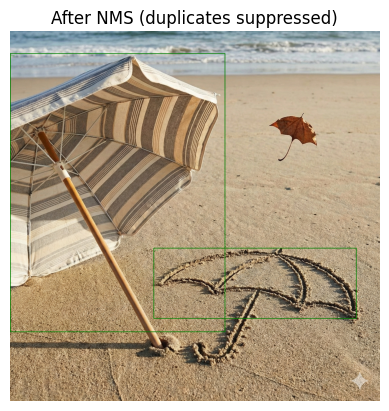

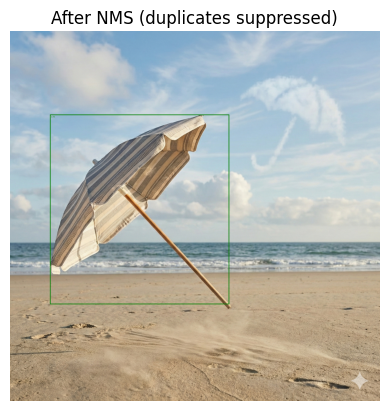

In [29]:
keep = nms(b, s, iou_threshold=0.15)
kept_b = [b[i] for i in keep]
kept_s = [s[i] for i in keep]

keep2 = nms(b2, s2, iou_threshold=0.15)
kept_b2 = [b2[i] for i in keep2]
kept_s2 = [s2[i] for i in keep2]

vis = draw_boxes(img1, kept_b, scores=kept_s, color="green")
vis2 = draw_boxes(img2, kept_b2, scores=kept_s2, color="green")

show(vis, "After NMS (duplicates suppressed)")
show(vis2, "After NMS (duplicates suppressed)")